In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

## EDA

In [69]:
train = pd.read_csv('data/train1.csv')
test = pd.read_csv('data/test1.csv')

df = pd.concat([train, test])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
df = df.drop('PassengerId', axis = 1)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [72]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [73]:
df.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [74]:
df.isna().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

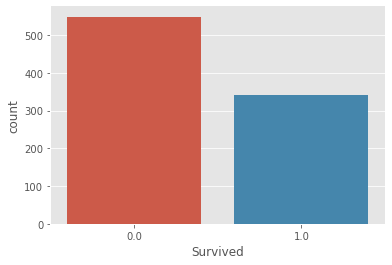

In [75]:
sns.countplot(df.Survived)
sns.despine()

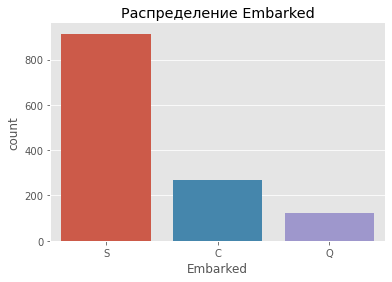

In [76]:
sns.countplot(df.Embarked)
plt.title('Распределение Embarked')
sns.despine()

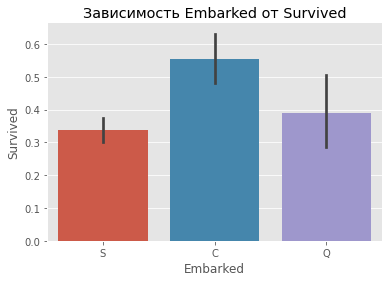

In [77]:
sns.barplot(df.Embarked, df.Survived)
plt.title('Зависимость Embarked от Survived')
sns.despine()

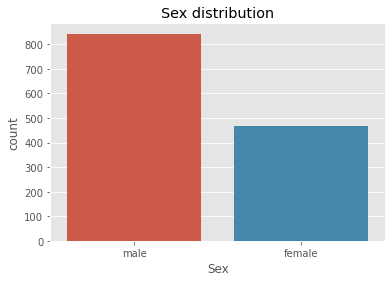

In [78]:
sns.countplot(df.Sex)
plt.title('Sex distribution')
plt.show()

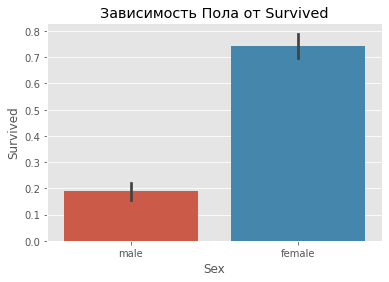

In [79]:
sns.barplot(df.Sex, df.Survived)
plt.title('Зависимость Пола от Survived')
plt.show()

In [80]:
pd.crosstab(df.Sex, df.Survived)

Survived,0.0,1.0
Sex,,
female,81,233
male,468,109


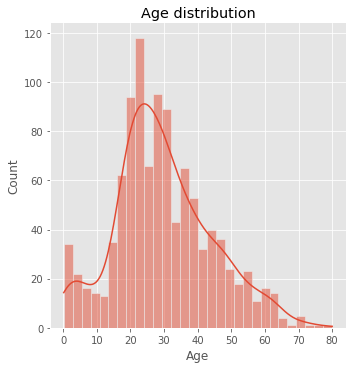

In [81]:
sns.displot(df.Age, kde = True, bins = 30)
plt.title('Age distribution')
sns.despine()

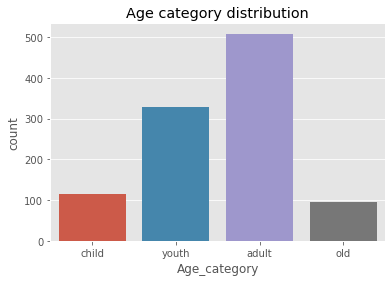

In [82]:
df['Age_category'] = pd.cut(df.Age, [0, 15, 25, 50, 80], labels = ['child', 'youth', 'adult', 'old'])
sns.countplot(df.Age_category)
plt.title('Age category distribution')
plt.show()

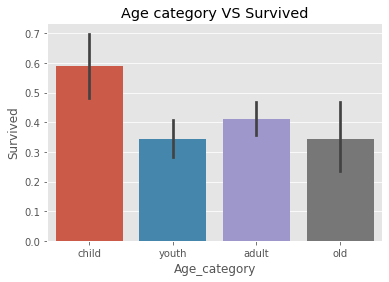

In [83]:
sns.barplot(df.Age_category, df.Survived)
plt.title('Age category VS Survived')
plt.show()

In [84]:
pd.crosstab(df.Age_category, df.Survived)

Survived,0.0,1.0
Age_category,,
child,34,49
youth,143,75
adult,205,144
old,42,22


In [85]:
df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [86]:
# как отличаются цены на билет взависимости от вида кабины и класса
df['Cabin_Symbol'] = df.Cabin.apply(lambda x: str(x)[0])

df.Cabin_Symbol.unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [87]:
# look to the most expensive cabins 
df.groupby(['Pclass', 'Cabin_Symbol'], as_index = False).agg({'Fare':'mean'})\
.sort_values(['Pclass', 'Fare'], ascending=[True, False])

,Pclass,Cabin_Symbol,Fare
1,1,B,122.383078
2,1,C,107.926598
6,1,n,70.268157
4,1,E,63.464706
3,1,D,58.919065
0,1,A,41.244314
5,1,T,35.500000
9,2,F,23.423077
10,2,n,21.394537
7,2,D,13.595833


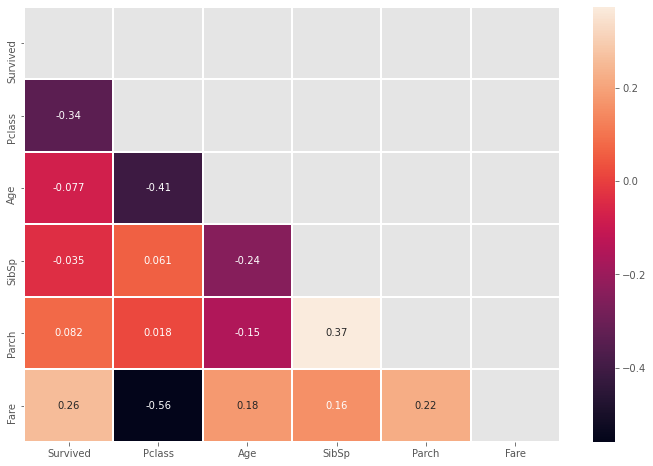

In [88]:
corr_matrix = df.corr()
plt.figure(figsize = (12, 8))
msk = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot = True, linewidths=1, mask = msk)
plt.show()

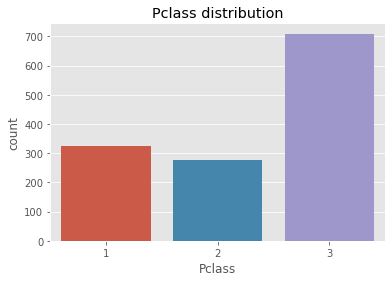

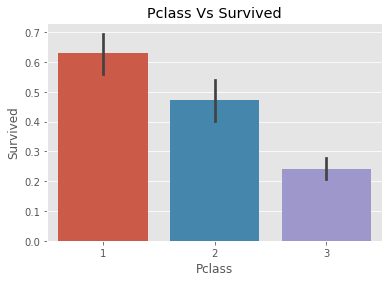

In [89]:
sns.countplot(df.Pclass)
plt.title('Pclass distribution')
plt.show()

sns.barplot(df.Pclass, df.Survived)
plt.title('Pclass Vs Survived')
plt.show()

In [90]:
pd.crosstab(df.Pclass, df.Survived)

Survived,0.0,1.0
Pclass,,
1,80,136
2,97,87
3,372,119


<Figure size 1008x1008 with 0 Axes>

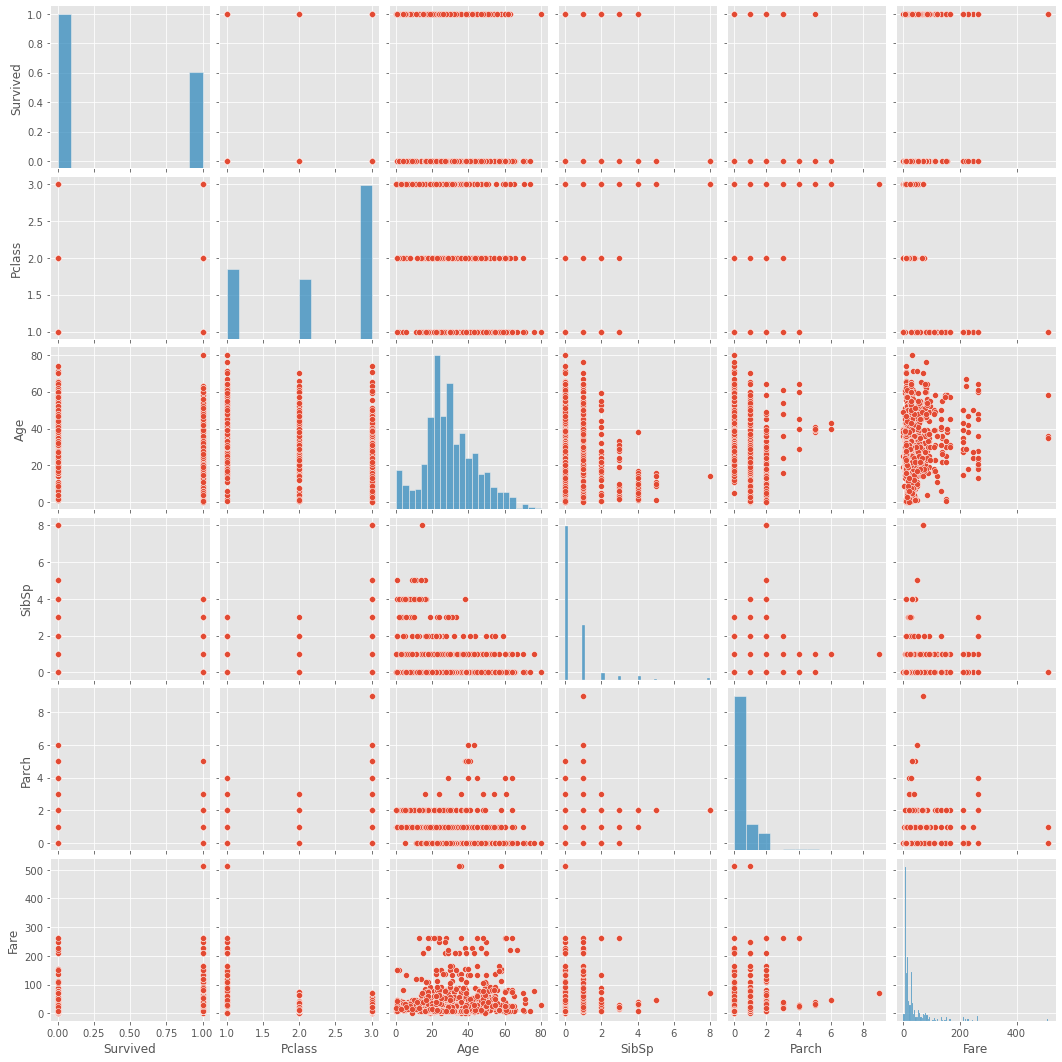

In [91]:
plt.figure(figsize = (14, 14))
sns.pairplot(df)
plt.show()

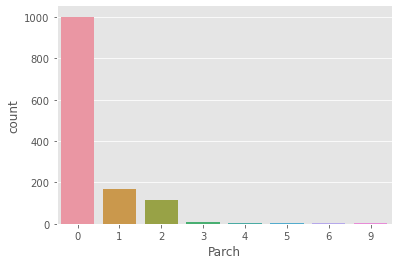

In [92]:
sns.countplot(df.Parch)
sns.despine()

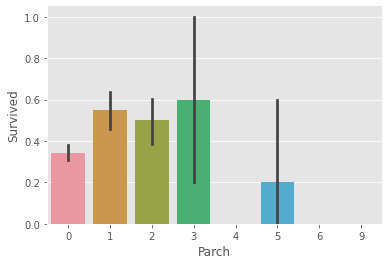

In [93]:
sns.barplot(df.Parch, df.Survived)
sns.despine()

In [94]:
df.Parch.value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [95]:
pd.crosstab(df.Parch, df.Survived)

Survived,0.0,1.0
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


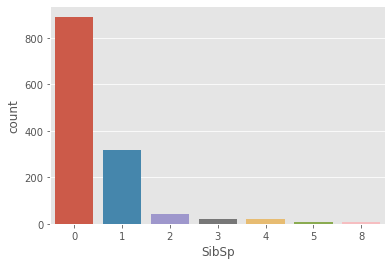

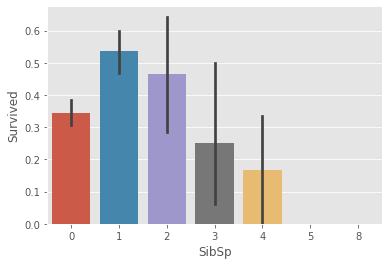

In [96]:
sns.countplot(df.SibSp)
plt.show()

sns.barplot(df.SibSp, df.Survived)
plt.show()

In [97]:
df.SibSp.value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [98]:
pd.crosstab(df.SibSp, df.Survived)

Survived,0.0,1.0
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


In [99]:
df['Exists_Parch'] = df.Parch.apply(lambda x: 1 if x>0 else 0)
df['Exists_SibSp'] = df.SibSp.apply(lambda x: 1 if x>0 else 0)

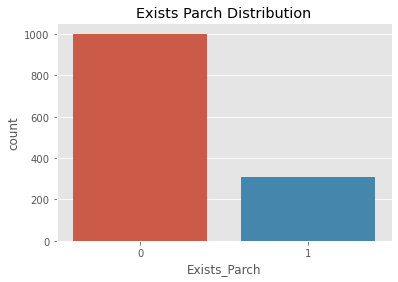

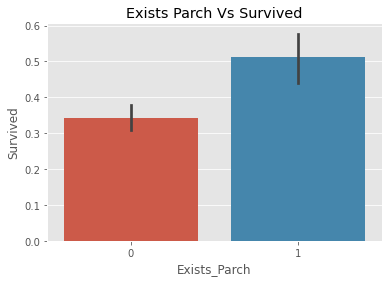

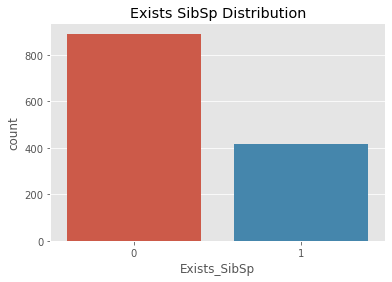

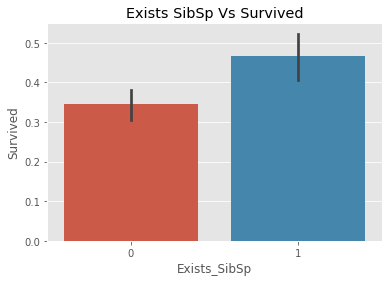

In [100]:
sns.countplot(df.Exists_Parch)
plt.title('Exists Parch Distribution')
plt.show()

sns.barplot(df.Exists_Parch, df.Survived)
plt.title('Exists Parch Vs Survived')
plt.show()

sns.countplot(df.Exists_SibSp)
plt.title('Exists SibSp Distribution')
plt.show()

sns.barplot(df.Exists_SibSp, df.Survived)
plt.title('Exists SibSp Vs Survived')
plt.show()

In [101]:
pd.crosstab(df.Exists_SibSp, df.Survived)

Survived,0.0,1.0
Exists_SibSp,,
0,398,210
1,151,132


In [102]:
pd.crosstab(df.Exists_Parch, df.Survived)

Survived,0.0,1.0
Exists_Parch,,
0,445,233
1,104,109


## Preprocessing

In [103]:
df = df.drop(['Name', 'Ticket'], axis = 1)

In [104]:
df.isna().sum()

Survived         418
Pclass             0
Sex                0
Age              263
SibSp              0
Parch              0
Fare               1
Cabin           1014
Embarked           2
Age_category     263
Cabin_Symbol       0
Exists_Parch       0
Exists_SibSp       0
dtype: int64

In [105]:
df.Age = df.Age.fillna(df.Age.median())
#df.Age = df.Age.fillna(0)

#df['Age_category'] = pd.cut(df.Age, [0, 14, 40, 80], labels = ['child', 'adult', 'old'])
#df['Age_category'] = pd.cut(df.Age, [0, 10, 20, 50, 80], labels = ['child', 'teen', 'adult', 'old'])
df['Age_category'] = pd.cut(df.Age, [0, 15, 25, 50, 80], labels = ['child', 'youth', 'adult', 'old'])

df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])

df.Fare = df.Fare.fillna(df.Fare.mean())

In [112]:
# Price cuts depending on their class and cabins
pd.set_option('display.max_rows', None)
df['Fare_bin'] = pd.cut(
    df.Fare, [i for i in range(round(df.Fare.min()), round(df.Fare.max()), 30)],
    labels=[i*30 for i in range(17)]
)
#we do this in order to find out in what interval the prices 
#for null-cabins are usually found, and find the most common known 
#cab with the same price of the interval, and then fill in the empty values
df.groupby(['Pclass', 'Cabin_Symbol', 'Fare_bin'])\
.agg({'Survived':'count'})\
.sort_values(['Pclass', 'Survived'], ascending = [True, False])\
.head()
# to look it fully erase head()

Survived
Pclass Cabin_Symbol Fare_bin          
1      C            60              14
       B            60              13
       D            60              13
       C            30              12
       n            0               12

In [113]:
df_pclass1 = df[df.Pclass == 1]
df_pclass2 = df[df.Pclass == 2]
df_pclass3 = df[df.Pclass == 3]

df_pclass1.Cabin = df_pclass1.Cabin.fillna('C')
df_pclass2.Cabin = df_pclass2.Cabin.fillna('F')
df_pclass3.Cabin = df_pclass3.Cabin.fillna('F')

df[df.Pclass == 1] = df_pclass1
df[df.Pclass == 2] = df_pclass2
df[df.Pclass == 3] = df_pclass3

In [114]:
df.isna().sum()

Survived        418
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Cabin             0
Embarked          0
Age_category      0
Cabin_Symbol      0
Exists_Parch      0
Exists_SibSp      0
Fare_bin         21
dtype: int64

In [115]:
df = df.drop(['Cabin_Symbol', 'Fare_bin'], axis = 1)

df.Cabin = df.Cabin.apply(lambda x: str(x)[0])
#df = df.drop('Cabin', axis=1)
df.Pclass = df.Pclass.astype(str)

In [44]:
# creating new features based on this columns
categorical_columns = []
for col in df.columns:
    if df[col].dtype != int and df[col].dtype != float:
        categorical_columns.append(col)
categorical_columns.remove('Sex')
categorical_columns

['Pclass', 'Embarked', 'Age_category']

In [45]:
for col in categorical_columns:
    df = pd.get_dummies(df, columns = [col])

In [46]:
df.Sex = pd.factorize(df.Sex)[0]
df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Exists_Parch,Exists_SibSp,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_category_child,Age_category_youth,Age_category_adult,Age_category_old
0,0.0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,1,0,0
1,1.0,1,38.0,1,0,71.2833,0,1,1,0,0,1,0,0,0,0,1,0
2,1.0,1,26.0,0,0,7.9250,0,0,0,0,1,0,0,1,0,0,1,0
3,1.0,1,35.0,1,0,53.1000,0,1,1,0,0,0,0,1,0,0,1,0
4,0.0,0,35.0,0,0,8.0500,0,0,0,0,1,0,0,1,0,0,1,0


In [47]:
print(df.shape)
print(train.shape)
print(test.shape)

(1309, 18)
(891, 12)
(418, 11)


## Model selecting

In [55]:
X = df.drop(['Survived'], axis = 1).iloc[:891]
y = df.Survived.iloc[:891]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = df.drop('Survived', axis = 1).iloc[891:]

sc = StandardScaler()
mm = MinMaxScaler()

X_train_scale = sc.fit_transform(X_train)
X_val_scale = sc.transform(X_val)

X_train_mm = mm.fit_transform(X_train)
X_val_mm = mm.transform(X_val)

In [56]:
pred_log_l2 = LogisticRegression(penalty='l2').fit(X_train, y_train).predict(X_val)
print(classification_report(y_val, pred_log_l2))


pred_log_l2_sc = LogisticRegression(penalty='l2').fit(X_train_scale, y_train).predict(X_val_scale)
print(classification_report(y_val, pred_log_l2_sc))

pred_log_l2_mm = LogisticRegression(penalty='l2').fit(X_train_mm, y_train).predict(X_val_mm)
print(classification_report(y_val, pred_log_l2_mm))

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       157
         1.0       0.79      0.71      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       157
         1.0       0.79      0.71      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       157
         1.0       0.80      0.71      0.75       111

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.80       268



In [57]:
pred_log_l1 = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, y_train).predict(X_val)
print(classification_report(y_val, pred_log_l1))

pred_log_l1_sc = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train_scale, y_train).predict(X_val_scale)
print(classification_report(y_val, pred_log_l1_sc))

pred_log_l1_mm = LogisticRegression(C = 0.1, penalty='l1', solver='liblinear').fit(X_train_mm, y_train).predict(X_val_mm)
print(classification_report(y_val, pred_log_l1_mm))

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       157
         1.0       0.80      0.70      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       157
         1.0       0.80      0.70      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.84       157
         1.0       0.82      0.68      0.74       111

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.79       268
weighted avg       0.81      0.81      0.80       268



In [58]:
pred_bag = BaggingClassifier(base_estimator=LogisticRegression(penalty='l1', solver='liblinear')).fit(X_train, y_train).predict(X_val)
print(classification_report(y_val, pred_bag))

pred_bag = BaggingClassifier(base_estimator=LogisticRegression(penalty='l1', solver='liblinear')).fit(X_train_mm, y_train).predict(X_val_mm)
print(classification_report(y_val, pred_bag))

pred_bag = BaggingClassifier(base_estimator=LogisticRegression(penalty='l1', solver='liblinear')).fit(X_train_scale, y_train).predict(X_val_scale)
print(classification_report(y_val, pred_bag))

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       157
         1.0       0.80      0.70      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84       157
         1.0       0.78      0.72      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       157
         1.0       0.77      0.71      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.79       268
weighted avg       0.79      0.79      0.79       268



In [59]:
model = Pipeline(steps = [('Scale', StandardScaler()),
                         ('Model', RandomForestClassifier())])
params = {
 'Model__max_depth': [1, 3, 5, 7],
 'Model__max_features': [3, 5, 7],
 'Model__n_estimators': [10, 50, 100],
 'Model__criterion' : ["gini", "entropy"],
 'Scale': [MinMaxScaler(), StandardScaler()]
}


grid = GridSearchCV(model, param_grid=params)
rfc = grid.fit(X_train, y_train)

In [60]:
rfc.best_estimator_

Pipeline(steps=[('Scale', MinMaxScaler()),
                ('Model',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_features=7, n_estimators=50))])

In [61]:
pred_rf = rfc.best_estimator_.predict(X_val_scale)
print(classification_report(y_val, pred_rf))

              precision    recall  f1-score   support

         0.0       0.77      0.06      0.12       157
         1.0       0.42      0.97      0.59       111

    accuracy                           0.44       268
   macro avg       0.60      0.52      0.35       268
weighted avg       0.63      0.44      0.31       268



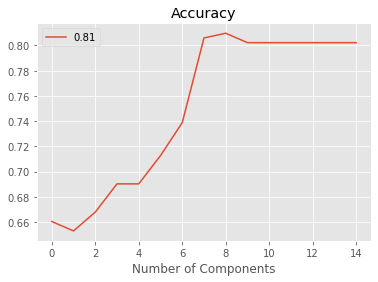

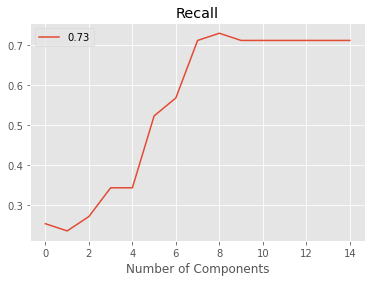

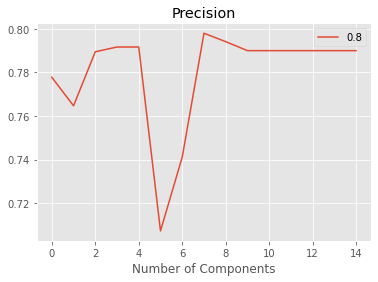

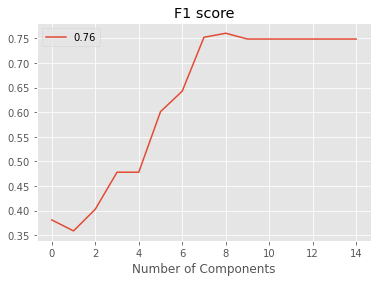

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = []
precision = []
recall = []
f_value = []
for i in range(1, len(df.columns)):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    pred_log_pca = LogisticRegression()\
    .fit(X_train_pca, y_train).predict(X_val_pca)
    accuracy.append(accuracy_score(y_val, pred_log_pca))
    recall.append(recall_score(y_val, pred_log_pca))
    precision.append(precision_score(y_val, pred_log_pca))
    f_value.append(f1_score(y_val, pred_log_pca))

plt.plot(accuracy, label = round(max(accuracy), 2))
plt.title('Accuracy')
plt.xlabel('Number of Components')
plt.legend(loc = 'best')
plt.show()
plt.plot(recall, label = round(max(recall), 2))
plt.title('Recall')
plt.xlabel('Number of Components')
plt.legend(loc = 'best')
plt.show()
plt.plot(precision, label = round(max(precision), 2))
plt.title('Precision')
plt.xlabel('Number of Components')
plt.legend(loc = 'best')
plt.show()
plt.plot(f_value, label = round(max(f_value), 2))
plt.title('F1 score')
plt.xlabel('Number of Components')
plt.legend(loc = 'best')
plt.show()

In [62]:
xgb = XGBClassifier( learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=2,
 subsample=0.8,            
 colsample_bytree=0.5,
 nthread=3,
 scale_pos_weight=1,
 seed=30)

pred_xgb = xgb.fit(X_train, y_train).predict(X_val)
print(classification_report(y_val, pred_xgb))

pred_xgb = xgb.fit(X_train_mm, y_train).predict(X_val_mm)
print(classification_report(y_val, pred_xgb))

pred_xgb = xgb.fit(X_train_scale, y_train).predict(X_val_scale)
print(classification_report(y_val, pred_xgb))

[18:51:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85       157
         1.0       0.83      0.70      0.76       111

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.81       268

[18:51:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85       157
         1.0       0.83      0.70      0.76       111

    a

In [63]:
cat = CatBoostClassifier()

pred_cat = cat.fit(X_train, y_train).predict(X_val)
print(classification_report(y_val, pred_cat))

Learning rate set to 0.008417
0:	learn: 0.6870222	total: 48.2ms	remaining: 48.2s
1:	learn: 0.6811848	total: 49.2ms	remaining: 24.6s
2:	learn: 0.6751167	total: 50.2ms	remaining: 16.7s
3:	learn: 0.6694339	total: 51.1ms	remaining: 12.7s
4:	learn: 0.6638647	total: 52ms	remaining: 10.3s
5:	learn: 0.6586099	total: 52.8ms	remaining: 8.74s
6:	learn: 0.6530115	total: 53.7ms	remaining: 7.62s
7:	learn: 0.6479908	total: 54.7ms	remaining: 6.78s
8:	learn: 0.6430481	total: 55.7ms	remaining: 6.13s
9:	learn: 0.6383990	total: 56.6ms	remaining: 5.6s
10:	learn: 0.6330161	total: 57.6ms	remaining: 5.18s
11:	learn: 0.6281411	total: 58.4ms	remaining: 4.81s
12:	learn: 0.6246299	total: 61.8ms	remaining: 4.7s
13:	learn: 0.6210298	total: 62.8ms	remaining: 4.42s
14:	learn: 0.6173048	total: 63.8ms	remaining: 4.19s
15:	learn: 0.6137907	total: 64.8ms	remaining: 3.98s
16:	learn: 0.6093178	total: 65.9ms	remaining: 3.81s
17:	learn: 0.6054947	total: 67ms	remaining: 3.66s
18:	learn: 0.6011040	total: 68ms	remaining: 3.51s


299:	learn: 0.3570301	total: 343ms	remaining: 801ms
300:	learn: 0.3568496	total: 344ms	remaining: 799ms
301:	learn: 0.3565444	total: 345ms	remaining: 798ms
302:	learn: 0.3563783	total: 346ms	remaining: 796ms
303:	learn: 0.3562551	total: 347ms	remaining: 794ms
304:	learn: 0.3561253	total: 348ms	remaining: 792ms
305:	learn: 0.3558922	total: 348ms	remaining: 790ms
306:	learn: 0.3557732	total: 349ms	remaining: 787ms
307:	learn: 0.3556733	total: 349ms	remaining: 785ms
308:	learn: 0.3556095	total: 350ms	remaining: 783ms
309:	learn: 0.3554657	total: 351ms	remaining: 781ms
310:	learn: 0.3554094	total: 351ms	remaining: 778ms
311:	learn: 0.3552475	total: 352ms	remaining: 776ms
312:	learn: 0.3549344	total: 353ms	remaining: 774ms
313:	learn: 0.3546922	total: 353ms	remaining: 772ms
314:	learn: 0.3546677	total: 354ms	remaining: 769ms
315:	learn: 0.3545050	total: 355ms	remaining: 767ms
316:	learn: 0.3543056	total: 355ms	remaining: 765ms
317:	learn: 0.3540659	total: 356ms	remaining: 764ms
318:	learn: 

538:	learn: 0.3240290	total: 532ms	remaining: 455ms
539:	learn: 0.3236208	total: 533ms	remaining: 454ms
540:	learn: 0.3235336	total: 534ms	remaining: 453ms
541:	learn: 0.3234454	total: 534ms	remaining: 452ms
542:	learn: 0.3233250	total: 535ms	remaining: 450ms
543:	learn: 0.3231168	total: 536ms	remaining: 449ms
544:	learn: 0.3230711	total: 536ms	remaining: 448ms
545:	learn: 0.3229006	total: 537ms	remaining: 447ms
546:	learn: 0.3228232	total: 538ms	remaining: 445ms
547:	learn: 0.3227632	total: 538ms	remaining: 444ms
548:	learn: 0.3225807	total: 539ms	remaining: 443ms
549:	learn: 0.3224511	total: 544ms	remaining: 445ms
550:	learn: 0.3224204	total: 545ms	remaining: 444ms
551:	learn: 0.3223361	total: 546ms	remaining: 443ms
552:	learn: 0.3221992	total: 547ms	remaining: 442ms
553:	learn: 0.3221534	total: 548ms	remaining: 441ms
554:	learn: 0.3219332	total: 549ms	remaining: 440ms
555:	learn: 0.3218776	total: 549ms	remaining: 439ms
556:	learn: 0.3217503	total: 550ms	remaining: 438ms
557:	learn: 

778:	learn: 0.2967977	total: 719ms	remaining: 204ms
779:	learn: 0.2967756	total: 720ms	remaining: 203ms
780:	learn: 0.2966033	total: 722ms	remaining: 202ms
781:	learn: 0.2964283	total: 722ms	remaining: 201ms
782:	learn: 0.2963881	total: 723ms	remaining: 200ms
783:	learn: 0.2963288	total: 724ms	remaining: 199ms
784:	learn: 0.2962512	total: 724ms	remaining: 198ms
785:	learn: 0.2961718	total: 726ms	remaining: 198ms
786:	learn: 0.2960044	total: 727ms	remaining: 197ms
787:	learn: 0.2959229	total: 728ms	remaining: 196ms
788:	learn: 0.2958779	total: 729ms	remaining: 195ms
789:	learn: 0.2958108	total: 730ms	remaining: 194ms
790:	learn: 0.2957677	total: 731ms	remaining: 193ms
791:	learn: 0.2955765	total: 732ms	remaining: 192ms
792:	learn: 0.2953580	total: 733ms	remaining: 191ms
793:	learn: 0.2952533	total: 734ms	remaining: 190ms
794:	learn: 0.2952064	total: 735ms	remaining: 189ms
795:	learn: 0.2950595	total: 735ms	remaining: 188ms
796:	learn: 0.2948031	total: 736ms	remaining: 187ms
797:	learn: 

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       157
         1.0       0.83      0.68      0.75       111

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



## Final Predict

In [65]:
sc = StandardScaler()
mm = MinMaxScaler()
X_scale = mm.fit_transform(X)
X_test_scale = mm.transform(X_test)

pred_log = LogisticRegression(C = 1, penalty='l1', solver='liblinear')\
.fit(X_scale, y)\
.predict(X_test_scale)

submission = test[['PassengerId']]
submission['Survived'] = pred_log.astype(int)
submission.to_csv('titanic_log_preds', index = False)

In [66]:
xgb = XGBClassifier( learning_rate =0.01,
 n_estimators=1500,
 max_depth=3,
 min_child_weight=2,
 subsample=0.8,    
 colsample_bytree=0.5,
 nthread=3,
 scale_pos_weight=1,
 seed=30)

sc = StandardScaler()
X_scale = sc.fit_transform(X)
X_test_scale = sc.transform(X_test)
preds_xgb = xgb.fit(X_scale, y).predict(X_test_scale)
submission = test[['PassengerId']]
submission['Survived'] = preds_xgb.astype(int)
submission.to_csv('titanic_xgb_preds', index = False)

[18:51:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)
pred_log_pca = LogisticRegression(penalty='l1', solver='liblinear').fit(X_pca, y).predict(X_test_pca)
submission = test[['PassengerId']]
submission['Survived'] = pred_log_pca.astype(int)
submission.to_csv('titanic_log_pca', index = False)